# Red Dragon Advanced CV Project
(Done by: Daniel Leong)

In this project, I will be training a Human Face Detector with YoloV4, instead of a person detector. The original trained weights are derived from training on the Coco 80 classes dataset, which already included the "Person" class. To change things up abit, I decided to finetune the model on an object that it hadn't trained on. 

The face dataset I used is from the [WIDER FACE dataset](http://shuoyang1213.me/WIDERFACE/). The following helper function annotates the images with their boundary boxes' x-y axes. For the training set, I capped out at 4000 images, as otherwise, it would take too long to train a single epoch.

In [1]:
def annotate():
    for s in ['val', 'train']:        
        with open(f'/src/data/wider_face_{s}_bbx_gt.txt', 'r', encoding='utf8') as f_in:
            with open(f'/src/data/{s}.txt', 'w') as f_out:
                nx = f_in.readline()
                count = 0
                while nx:
                    if count > 4000:
                        break
                    count += 1
                    string = nx.rsplit()[0] + ' '
                    num_bboxes = int(f_in.readline())
                    if num_bboxes > 0:                        
                        for i in range(num_bboxes):
                            boundary = f_in.readline().split()
                            x1 = boundary[0] # left
                            y1 = boundary[1] # top
                            x2 = str(int(x1) + int(boundary[2])) # right
                            y2 = str(int(y1) + int(boundary[3])) # bottom
                            string_append = f'{x1},{y1},{x2},{y2},0 '
                            string = string + string_append
                        string = f'/src/data/{s}/' + string[:-1] + '\n'
                        f_out.write(string)
                    else:
                        # skip line
                        f_in.readline()
                    nx = f_in.readline()
                    
# annotate()

## Pytorch Model Implementation
The following implementation is written in Pytorch, forked from [Tianxiaomo's repository](https://github.com/Tianxiaomo/pytorch-YOLOv4). Parts of the scripts on the model's structure code re-written as I found them a little repetitive. More specifically, the multiple DownSample layers were combined to DownSampleLayer with some added initialization inputs. I realized that other than the first layer, each subsequent DownSample layer merely had an increase in the number of channels by an order magnitude of 2. There was no need for a separate DownSample class for each of the 4 subsequent layers when this pattern is taken into account.

The model's structure can be found here. For the full implementation, please look at [my repository here](https://github.com/test-dan-run/yolov4-detect/tree/master/human_face_detector). The required packages are found in the requirements.txt file, and it would be easier if you load up the Dockerfile.

In [1]:
import cv2

import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from collections import deque

import os, sys
from tqdm import tqdm
from cfg import Cfg as config

from tensorboardX import SummaryWriter

from dataset import Yolo_dataset
from models import Yolov4
from losses import *
from tools.torch_utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x * (torch.tanh(torch.nn.functional.softplus(x)))
        return x

class Upsample(nn.Module):
    def __init__(self):
        super(Upsample, self).__init__()

    def forward(self, x, target_size, inference=False):
        assert (x.data.dim() == 4)
        # _, _, tH, tW = target_size

        if inference:

            #B = x.data.size(0)
            #C = x.data.size(1)
            #H = x.data.size(2)
            #W = x.data.size(3)

            return x.view(x.size(0), x.size(1), x.size(2), 1, x.size(3), 1).\
                    expand(x.size(0), x.size(1), x.size(2), target_size[2] // x.size(2), x.size(3), target_size[3] // x.size(3)).\
                    contiguous().view(x.size(0), x.size(1), target_size[2], target_size[3])
        else:
            return F.interpolate(x, size=(target_size[2], target_size[3]), mode='nearest')

class Conv_Bn_Activation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, activation, bn=True, bias=False):
        super().__init__()
        pad = (kernel_size - 1) // 2

        self.conv = nn.ModuleList()
        if bias:
            self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad))
        else:
            self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False))
        if bn:
            self.conv.append(nn.BatchNorm2d(out_channels))
        if activation == "mish":
            self.conv.append(Mish())
        elif activation == "relu":
            self.conv.append(nn.ReLU(inplace=True))
        elif activation == "leaky":
            self.conv.append(nn.LeakyReLU(0.1, inplace=True))
        elif activation == "linear":
            pass
        else:
            print("activate error !!! {} {} {}".format(sys._getframe().f_code.co_filename,
                                                       sys._getframe().f_code.co_name, sys._getframe().f_lineno))

    def forward(self, x):
        for l in self.conv:
            x = l(x)
        return x

class ResBlock(nn.Module):
    """
    Sequential residual blocks each of which consists of \
    two convolution layers.
    Args:
        ch (int): number of input and output channels.
        nblocks (int): number of residual blocks.
        shortcut (bool): if True, residual tensor addition is enabled.
    """

    def __init__(self, ch, nblocks=1, shortcut=True):
        super().__init__()
        self.shortcut = shortcut
        self.module_list = nn.ModuleList()
        for i in range(nblocks):
            resblock_one = nn.ModuleList()
            resblock_one.append(Conv_Bn_Activation(ch, ch, 1, 1, 'mish'))
            resblock_one.append(Conv_Bn_Activation(ch, ch, 3, 1, 'mish'))
            self.module_list.append(resblock_one)

    def forward(self, x):
        for module in self.module_list:
            h = x
            for res in module:
                h = res(h)
            x = x + h if self.shortcut else h
        return x

class DownSampleFirstLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv_Bn_Activation(3, 32, 3, 1, 'mish')

        self.conv2 = Conv_Bn_Activation(32, 64, 3, 2, 'mish')
        self.conv3 = Conv_Bn_Activation(64, 64, 1, 1, 'mish')
        # [route]
        # layers = -2
        self.conv4 = Conv_Bn_Activation(64, 64, 1, 1, 'mish')

        self.conv5 = Conv_Bn_Activation(64, 32, 1, 1, 'mish')
        self.conv6 = Conv_Bn_Activation(32, 64, 3, 1, 'mish')
        # [shortcut]
        # from=-3
        # activation = linear

        self.conv7 = Conv_Bn_Activation(64, 64, 1, 1, 'mish')
        # [route]
        # layers = -1, -7
        self.conv8 = Conv_Bn_Activation(128, 64, 1, 1, 'mish')

    def forward(self, input):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        # route -2
        x4 = self.conv4(x2)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        # shortcut -3
        x6 = x6 + x4

        x7 = self.conv7(x6)
        # [route]
        # layers = -1, -7
        x7 = torch.cat([x7, x3], dim=1)
        x8 = self.conv8(x7)
        return x8

class DownSampleLayer(nn.Module):
    def __init__(self, layer=2, num_res_blocks=2):
        super().__init__()
        chnl = 32 * (2 ** (layer-1))

        self.conv1 = Conv_Bn_Activation(chnl, 2*chnl, 3, 2, 'mish')
        self.conv2 = Conv_Bn_Activation(2*chnl, chnl, 1, 1, 'mish')
        # r -2
        self.conv3 = Conv_Bn_Activation(2*chnl, chnl, 1, 1, 'mish')
        self.resblock = ResBlock(chnl, nblocks=num_res_blocks)
        # s -3
        self.conv4 = Conv_Bn_Activation(chnl, chnl, 1, 1, 'mish')
        self.conv5 = Conv_Bn_Activation(2*chnl, 2*chnl, 1, 1, 'mish')

    def forward(self, input):

        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x1)

        r = self.resblock(x3)
        x4 = self.conv4(r)

        x4 = torch.cat([x4, x2], dim=1)
        x5 = self.conv5(x4)

        return x5

class Neck(nn.Module):
    def __init__(self, inference=False):
        super().__init__()
        self.inference = inference

        self.conv1 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv2 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv3 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        # SPP
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=5 // 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=9 // 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=13 // 2)

        # R -1 -3 -5 -6
        # SPP
        self.conv4 = Conv_Bn_Activation(2048, 512, 1, 1, 'leaky')
        self.conv5 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv6 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv7 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        # UP
        self.upsample1 = Upsample()
        # R 85
        self.conv8 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        # R -1 -3
        self.conv9 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv10 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv11 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv12 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv13 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv14 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        # UP
        self.upsample2 = Upsample()
        # R 54
        self.conv15 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        # R -1 -3
        self.conv16 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        self.conv17 = Conv_Bn_Activation(128, 256, 3, 1, 'leaky')
        self.conv18 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')
        self.conv19 = Conv_Bn_Activation(128, 256, 3, 1, 'leaky')
        self.conv20 = Conv_Bn_Activation(256, 128, 1, 1, 'leaky')

    def forward(self, input, downsample4, downsample3):
        x1 = self.conv1(input)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        # SPP
        m1 = self.maxpool1(x3)
        m2 = self.maxpool2(x3)
        m3 = self.maxpool3(x3)
        spp = torch.cat([m3, m2, m1, x3], dim=1)
        # SPP end
        x4 = self.conv4(spp)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        # UP
        up = self.upsample1(x7, downsample4.size(), inference=self.inference)
        # R 85
        x8 = self.conv8(downsample4)
        # R -1 -3
        x8 = torch.cat([x8, up], dim=1)

        x9 = self.conv9(x8)
        x10 = self.conv10(x9)
        x11 = self.conv11(x10)
        x12 = self.conv12(x11)
        x13 = self.conv13(x12)
        x14 = self.conv14(x13)

        # UP
        up = self.upsample2(x14, downsample3.size(), self.inference)
        # R 54
        x15 = self.conv15(downsample3)
        # R -1 -3
        x15 = torch.cat([x15, up], dim=1)

        x16 = self.conv16(x15)
        x17 = self.conv17(x16)
        x18 = self.conv18(x17)
        x19 = self.conv19(x18)
        x20 = self.conv20(x19)
        return x20, x13, x6

class Yolov4Head(nn.Module):
    def __init__(self, output_ch, n_classes, inference=False):
        super().__init__()
        self.inference = inference

        self.conv1 = Conv_Bn_Activation(128, 256, 3, 1, 'leaky')
        self.conv2 = Conv_Bn_Activation(256, output_ch, 1, 1, 'linear', bn=False, bias=True)

        # R -4
        self.conv3 = Conv_Bn_Activation(128, 256, 3, 2, 'leaky')

        # R -1 -16
        self.conv4 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv5 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv6 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv7 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv8 = Conv_Bn_Activation(512, 256, 1, 1, 'leaky')
        self.conv9 = Conv_Bn_Activation(256, 512, 3, 1, 'leaky')
        self.conv10 = Conv_Bn_Activation(512, output_ch, 1, 1, 'linear', bn=False, bias=True)

        # R -4
        self.conv11 = Conv_Bn_Activation(256, 512, 3, 2, 'leaky')

        # R -1 -37
        self.conv12 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv13 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv14 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv15 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv16 = Conv_Bn_Activation(1024, 512, 1, 1, 'leaky')
        self.conv17 = Conv_Bn_Activation(512, 1024, 3, 1, 'leaky')
        self.conv18 = Conv_Bn_Activation(1024, output_ch, 1, 1, 'linear', bn=False, bias=True)

        self.yolo1 = YoloLayer(
                            anchor_mask=[0, 1, 2], num_classes=n_classes,
                            anchors=[12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401],
                            num_anchors=9, stride=8)
        self.yolo2 = YoloLayer(
                                anchor_mask=[3, 4, 5], num_classes=n_classes,
                                anchors=[12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401],
                                num_anchors=9, stride=16)
        self.yolo3 = YoloLayer(
                                anchor_mask=[6, 7, 8], num_classes=n_classes,
                                anchors=[12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401],
                                num_anchors=9, stride=32)

    def forward(self, input1, input2, input3):
        x1 = self.conv1(input1)
        x2 = self.conv2(x1)

        x3 = self.conv3(input1)
        # R -1 -16
        x3 = torch.cat([x3, input2], dim=1)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)
        x9 = self.conv9(x8)
        x10 = self.conv10(x9)

        # R -4
        x11 = self.conv11(x8)
        # R -1 -37
        x11 = torch.cat([x11, input3], dim=1)

        x12 = self.conv12(x11)
        x13 = self.conv13(x12)
        x14 = self.conv14(x13)
        x15 = self.conv15(x14)
        x16 = self.conv16(x15)
        x17 = self.conv17(x16)
        x18 = self.conv18(x17)

        if self.inference:
            y1 = self.yolo1(x2)
            y2 = self.yolo2(x10)
            y3 = self.yolo3(x18)

            return get_region_boxes([y1, y2, y3])

        return [x2, x10, x18]

class Yolov4(nn.Module):
  def __init__(self, yolov4conv137weight=None, n_classes=80, inference=False):
    super().__init__()

    output_ch = (4 + 1 + n_classes) * 3

    # backbone
    self.down1 = DownSampleFirstLayer()
    self.down2 = DownSampleLayer(layer=2, num_res_blocks=2)
    self.down3 = DownSampleLayer(layer=3, num_res_blocks=8)
    self.down4 = DownSampleLayer(layer=4, num_res_blocks=8)
    self.down5 = DownSampleLayer(layer=5, num_res_blocks=4)

    # neck
    self.neck = Neck(inference)
    # yolov4conv137
    if yolov4conv137weight:
      _model = nn.Sequential(self.down1, self.down2, self.down3, self.down4, self.down5, self.neck)
      pretrained_dict = torch.load(yolov4conv137weight)

      model_dict = _model.state_dict()
      # 1. filter out unnecessary keys
      pretrained_dict = {k1: v for (k, v), k1 in zip(pretrained_dict.items(), model_dict)}
      # 2. overwrite entries in the existing state dict
      model_dict.update(pretrained_dict)
      _model.load_state_dict(model_dict)
    
    # head
    self.head = Yolov4Head(output_ch, n_classes, inference)

  def forward(self, input):
    
    d1 = self.down1(input)
    d2 = self.down2(d1)
    d3 = self.down3(d2)
    d4 = self.down4(d3)
    d5 = self.down5(d4)

    x20, x13, x6 = self.neck(d5, d4, d3)

    output = self.head(x20, x13, x6)
    return output

## Loading the Datasets
We will be using Pytorch's dataset and dataloader objects to make the process easier. We will be also be using the SummaryWriter to write logs into tensorboard for viewing the losses later.

In [3]:
train_dataset = Yolo_dataset(config.train_label, config)
val_dataset = Yolo_dataset(config.val_label, config)

n_train = len(train_dataset)
n_val = len(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=config.batch // config.subdivisions, shuffle=True,
                          num_workers=12, pin_memory=True, drop_last=True, collate_fn=collate)

val_loader = DataLoader(val_dataset, batch_size=config.batch // config.subdivisions, shuffle=True, num_workers=12,
                        pin_memory=True, drop_last=True)

writer = SummaryWriter(log_dir=config.TRAIN_TENSORBOARD_DIR,
                           filename_suffix=f'OPT_{config.TRAIN_OPTIMIZER}_LR_{config.learning_rate}_BS_{config.batch}_Sub_{config.subdivisions}_Size_{config.width}',
                           comment=f'OPT_{config.TRAIN_OPTIMIZER}_LR_{config.learning_rate}_BS_{config.batch}_Sub_{config.subdivisions}_Size_{config.width}')

In [4]:
# learning rate setup
def burnin_schedule(i):
    if i < config.burn_in:
        factor = pow(i / config.burn_in, 4)
    elif i < config.steps[0]:
        factor = 1.0
    elif i < config.steps[1]:
        factor = 0.1
    else:
        factor = 0.01
    return factor

## Model Initialization
We will be using the Adam optimizer, with a learning rate scheduler. The model is initialized according to the weights trained on the 80 COCO classes. Seeing that even with the weights loaded correctly with my revised DownSampleLayer implementation, it seems my implementation works as it should. 

In [3]:
model = Yolov4(config.pretrained, n_classes=config.classes) # n_classes = 1 (since we only looking at faces)
model.to(device=device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate / config.batch, betas=(0.9, 0.999), eps=1e-08)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, burnin_schedule)
criterion = Yolo_loss(device=device, batch=config.batch // config.subdivisions,n_classes=config.classes)

NameError: name 'burnin_schedule' is not defined

## Model Training
We're now at the training step. Training is stopped after 10 epochs, as I judged that the model has trained sufficiently enough based on the level of loss convergence. Screenshots of the tensorboard results will be shown in [my repository here]().

In [6]:
global_step = 0
saved_models = deque()

for epoch in range(config.TRAIN_EPOCHS):
    epoch_loss = 0
    epoch_step = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{config.TRAIN_EPOCHS}', unit='img', ncols=50) as pbar:
        for i, batch in enumerate(train_loader):
            global_step += 1
            epoch_step += 1
            images = batch[0]
            bboxes = batch[1]

            images = images.to(device=device, dtype=torch.float32)
            bboxes = bboxes.to(device=device)

            bboxes_pred = model(images)
            loss, loss_xy, loss_wh, loss_obj, loss_cls, loss_l2 = criterion(bboxes_pred, bboxes)
            loss.backward()

            epoch_loss += loss.item()

            if global_step  % config.subdivisions == 0:
                optimizer.step()
                scheduler.step()
                model.zero_grad()

            if global_step % (20 * config.subdivisions) == 0:
                writer.add_scalar('train/Loss', loss.item(), global_step)
                writer.add_scalar('train/loss_xy', loss_xy.item(), global_step)
                writer.add_scalar('train/loss_wh', loss_wh.item(), global_step)
                writer.add_scalar('train/loss_obj', loss_obj.item(), global_step)
                writer.add_scalar('train/loss_cls', loss_cls.item(), global_step)
                writer.add_scalar('train/loss_l2', loss_l2.item(), global_step)
                writer.add_scalar('lr', scheduler.get_lr()[0] * config.batch, global_step)

            pbar.update(images.shape[0])
    try:
        os.makedirs(config.checkpoints, exist_ok=True)
    except OSError:
        pass
    save_path = os.path.join(config.checkpoints, f'{epoch + 1}.pth')
    torch.save(model.state_dict(), save_path)
    saved_models.append(save_path)
    if len(saved_models) > config.keep_checkpoint_max > 0:
        model_to_remove = saved_models.popleft()
        try:
            os.remove(model_to_remove)
        except:
            pass
writer.close()

Epoch 1/300:   0%|      | 0/3999 [00:00<?, ?img/s]/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/300:   8%| | 318/3999 [04:03<45:55,  1.34i/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
Epoch 1/300: 100%|▉| 3998/3999 [50:11<00:00,  1.33
Epoch 2/300: 100%|▉| 3998/3999 [48:46<00:00,  1.37
Epoch 3/300: 100%|▉| 3998/3999 [47:12<00:00,  1.41
Epoch 4/300: 100%|▉| 3998/3999 [47:13<00:00,  1.41
Epoch 5/300: 100%|▉| 3998/3999 [47:12<00:00,  1.41
Epoch 6/300: 100%|▉| 3998/3999 [46:49<00:00,  1.42
Epoch 7/300: 100%|▉| 3998/3999 [46:46<00:00,  1.42
Epoch 8/300: 100%|▉| 3998/3999 [46:52<00:00,  1.42
Epoch 9/300: 100%|▉| 3998/3999 [46:54<00:00, 

KeyboardInterrupt: 

## Inference
We then finally set up an inference pipeline and see if the detector works as it should.

In [2]:
model = Yolov4(None, n_classes=config.classes, inference=True)
pretrained_dict = torch.load(config.trained, map_location=torch.device('cuda'))
model.load_state_dict(pretrained_dict)
model.to(device=device)

Yolov4(
  (down1): DownSampleFirstLayer(
    (conv1): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv2): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv3): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv4): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1)

In [3]:
from tools.utils import plot_boxes_cv2

In [4]:
img = cv2.imread('/src/data/train/0--Parade/0_Parade_marchingband_1_5.jpg')
sized = cv2.resize(img, (config.width, config.height))
sized = cv2.cvtColor(sized, cv2.COLOR_BGR2RGB)

bboxes = do_detect(model, sized, 0.5, 0.4, 1)

-----------------------------------
           Preprocess : 0.009307
      Model Inference : 0.707193
-----------------------------------
-----------------------------------
       max and argmax : 0.001014
                  nms : 0.001678
Post processing total : 0.002692
-----------------------------------


In [7]:
plot_boxes_cv2(img, bboxes[0], 'predictions.jpg', ['face'])

face: 0.773730
face: 0.745445
face: 0.717714
face: 0.634010
save plot results to predictions.jpg


array([[[ 37,  30,  35],
        [ 56,  48,  58],
        [ 79,  73,  90],
        ...,
        [239, 212, 208],
        [245, 216, 212],
        [249, 220, 216]],

       [[ 40,  33,  38],
        [ 56,  49,  56],
        [ 76,  70,  87],
        ...,
        [243, 216, 212],
        [247, 218, 214],
        [250, 221, 217]],

       [[ 43,  36,  39],
        [ 56,  50,  55],
        [ 74,  67,  82],
        ...,
        [247, 219, 218],
        [247, 219, 218],
        [248, 220, 219]],

       ...,

       [[ 92, 134, 123],
        [ 86, 128, 117],
        [ 80, 122, 111],
        ...,
        [ 87, 130, 117],
        [ 87, 130, 117],
        [ 83, 126, 113]],

       [[ 84, 126, 115],
        [ 80, 123, 112],
        [ 76, 118, 107],
        ...,
        [ 87, 130, 117],
        [ 86, 129, 116],
        [ 82, 125, 112]],

       [[ 76, 119, 108],
        [ 73, 119, 107],
        [ 73, 116, 105],
        ...,
        [ 90, 130, 118],
        [ 88, 128, 116],
        [ 82, 122, 110]]

In [3]:
from PIL import Image

image = Image.open('predictions.jpg')

On first glance, it seems like the model did pretty well as long as the faces are uncovered and are of sufficient clarity. (For example the drummer on the far left has a blurred face, and isn't detected.)

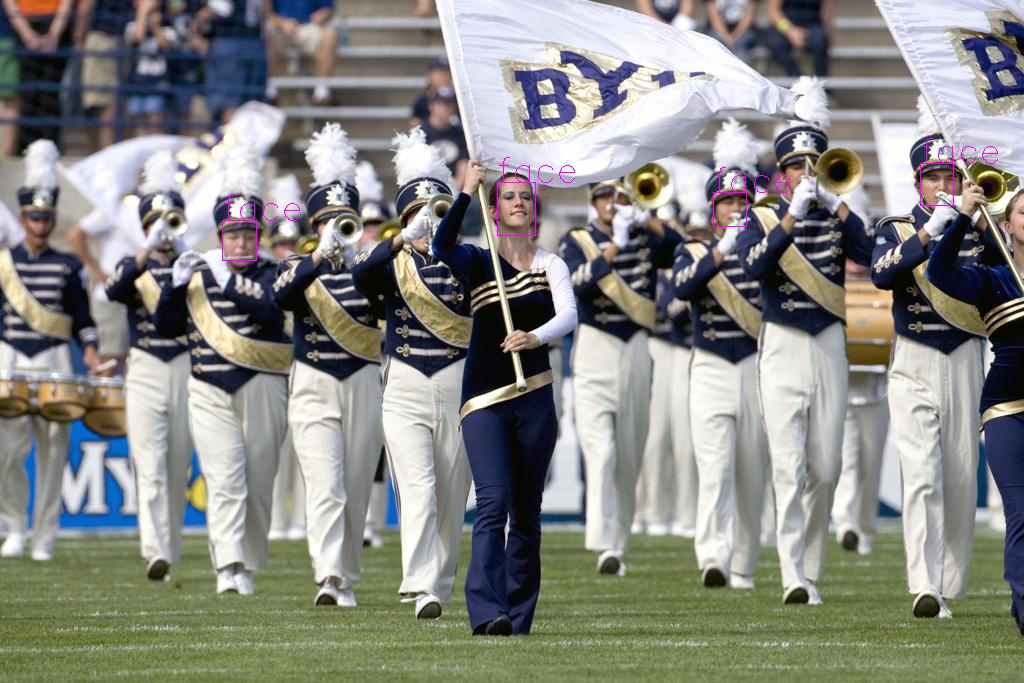

In [5]:
image

## Conclusion

In this notebook, I have demonstrated how to set up a training and inference pipeline for finetuning a YOLOv4 model to my use case - in which case is a human face detector. The existing forked code was also slightly rewritten, as I wanted to make sure I read through and understood the model from the ground-up, instead of copying and pasting the code wholesale and run training just like that. 

In this COVID-19 era, it would be helpful if we could track who isn't wearing a mask, or the number of people in close proximity, and the YOLOv4 detector would be the first step in achieving so. 